In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plot

In [2]:
def detect_hand_region(img, show=False):
    # converting from gbr to hsv color space
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # skin color range for hsv color space
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255))
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    # converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # skin color range for hsv color space
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135))
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    # merge skin detection (YCbCr and hsv)
    global_mask = cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask = cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))

    #show results
    if show:
        cv2.imshow("1_HSV",HSV_mask)
        cv2.imshow("2_YCbCr",YCrCb_mask)
        cv2.imshow("3_global_result",global_mask)
        cv2.imshow("org",img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    return global_mask

In [3]:
def is_contour_close_to_border(contour, img_shape, threshold=0.1):
    x = contour[:,:,0]
    y = contour[:,:,1]
    # left, right = min(x), max(x)
    # top, bottom = min(y), max(y)
    bottom = max(y)[0]
    height, width = img_shape[:2]
    
    if height - bottom < height * threshold:
        return True
    return False


def identify_hand_contour(binary, img_shape, show=False):
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=lambda x: len(x), reverse=True)
    
    hand_contour = None
    for cnt in contours:
        if is_contour_close_to_border(cnt, img_shape):
            hand_contour = cnt
            break
    
    if hand_contour is not None:
        if show:
            draw_cnt = np.zeros((binary.shape[0], binary.shape[1], 3), dtype=np.uint8)
            cv2.drawContours(draw_cnt, [hand_contour], 0, (255,255,0), 2)
            cv2.imshow("hand contour",draw_cnt)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    else:
        print('No hand region found')
    return hand_contour

In [4]:
def detect_fingertip(contour, show=False, image=None):
    fingertip = min(contour, key=lambda x: x[0][1])       
    fingertip = np.reshape(fingertip, (2))
    
    if show and image is not None:
        board = image.copy()
        cv2.circle(board, fingertip, 5, (0,255,0), 2)
        cv2.imshow('fingertip', board)
        cv2.waitKey()
        cv2.destroyAllWindows()
    return fingertip

In [5]:
# Open a simple image
# img=cv2.imread("h1.jpg")

# binary = detect_hand_region(img)
# hand_contour = identify_hand_contour(binary)
# detect_fingertip(hand_contour, image=img)

In [19]:
# *******************************
# *** Adjust Video Clip Range ***
# *******************************

import cv2

def nothing(x):
    pass


cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

fingertips = []

while(1):
    ret, frame = cap.read()
    frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    
    # 1. Color-range-based hand region detection and binarization
    binary = detect_hand_region(frame)
    cv2.imshow("binary", binary)
    
    # 2. Identify hand contour
    hand_contour = identify_hand_contour(binary, frame.shape)
    if hand_contour is not None:
        draw_cnt = np.zeros((binary.shape[0], binary.shape[1], 3), dtype=np.uint8)
        cv2.drawContours(draw_cnt, [hand_contour], 0, (255,255,0), 2)
        cv2.imshow("hand contour",draw_cnt)
    
    # 3. Detect the fingertip
    if hand_contour is not None:
        fingertip = detect_fingertip(hand_contour)
        fingertips.append(fingertip)
        draw_fingertip = frame.copy()
        cv2.circle(draw_fingertip, fingertip, 5, (0,255,0), 2)
        cv2.imshow('fingertip', draw_fingertip)
    else:
        fingertips.append([-1,frame.shape[0]])
        
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found
No hand region found


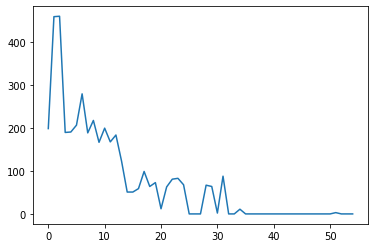

In [27]:
fingertips_v = [frame.shape[0] - p[1] for p in fingertips]
plot.plot(fingertips_v)

In [38]:
groups_id = []
start = -1
for i, pnt in enumerate(fingertips_v):
    if start == -1:
        if pnt != 0:
            start = i
    else:
        if pnt == 0:
            groups_id.append([start, i])
            start = -1

In [41]:
fingertips_frame_groups = [fingertips[gid[0]:gid[1]] for gid in groups_id]

In [42]:
fingertips_frame_groups

[[array([489, 761], dtype=int32),
  array([445, 500], dtype=int32),
  array([432, 499], dtype=int32),
  array([268, 770], dtype=int32),
  array([339, 769], dtype=int32),
  array([517, 753], dtype=int32),
  array([504, 680], dtype=int32),
  array([508, 771], dtype=int32),
  array([531, 742], dtype=int32),
  array([511, 793], dtype=int32),
  array([515, 760], dtype=int32),
  array([524, 792], dtype=int32),
  array([508, 776], dtype=int32),
  array([528, 837], dtype=int32),
  array([479, 909], dtype=int32),
  array([505, 909], dtype=int32),
  array([530, 901], dtype=int32),
  array([484, 861], dtype=int32),
  array([482, 896], dtype=int32),
  array([529, 887], dtype=int32),
  array([529, 948], dtype=int32),
  array([488, 897], dtype=int32),
  array([537, 879], dtype=int32),
  array([477, 877], dtype=int32),
  array([516, 892], dtype=int32)],
 [array([537, 893], dtype=int32),
  array([513, 896], dtype=int32),
  array([511, 958], dtype=int32),
  array([491, 872], dtype=int32)],
 [array([533

In [44]:
for grp in fingertips_frame_groups:
    print(min(grp, key=lambda x: x[1]))

[432 499]
[491 872]
[533 949]
[509 957]
